## Please run this notebook on Colab with GPU.

In [1]:
!pip install -Uqq datasets requests torch peft bitsandbytes trl accelerate sentencepiece

In [1]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import random
import wandb
import transformers
from pprint import pprint
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import PeftModel, LoraConfig
from datasets import load_dataset
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Constants
BASE_MODEL = 'unsloth/Meta-Llama-3.1-8B'

# Hyperparameters for QLoRA Fine-Tuning
LORA_R = 32
LORA_ALPHA = 64
LORA_DROPOUT = 0.05
TARGET_MODULES = ['q_proj', 'v_proj', 'k_proj', 'o_proj']

 # Q = query ("What word am I looking for?")
 # K = keys ("What words do I have?"))
 # V = value ("What should I return?")
 # O = outputs

In [3]:
# Login to Huggingface
HF_TOKEN = userdata.get('HUGGINGFACE_TOKEN')
login(token=HF_TOKEN, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Price pridiction with base LLaMA 3.1

In [4]:
# Constants
BASE_MODEL = 'unsloth/Meta-Llama-3.1-8B'
DATASET_NAME = 'cshyang/amazon-pricer-data'
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

## Load our Amazon Pricing Data

In [5]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Without quantization, the model takes up 32GB.
With 4-bit quantization, the model only takes up 5GB.

In [7]:
## Quantization
if QUANT_4_BIT:
    quantize_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
else:
    quantize_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.bfloat16,
    )

In [8]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token # If the token ever need to pad the token, it should use the end of sentence toekn
tokenizer.padding_side = "right" # The tokenizer should pad from the right side

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quantize_config,
    device_map='auto',
)

base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:,.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5.6 GB


In [12]:
# A utility function to extract the price from a string

def extract_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [13]:
def model_predict(prompt):
  set_seed(42)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)
  attention_mask = torch.ones(inputs.shape, device=device)
  output = base_model.generate(inputs, max_new_tokens=5, attention_mask=attention_mask, num_return_sequences=1)
  response = tokenizer.decode(output[0], skip_special_tokens=True)
  return extract_price(response)

In [11]:
model_predict(test[0]['prompt'])

4.0

In [12]:
pprint(test[0]['price'])

97.99


## Evaluate the LLaMA3.1 Base Model!

In [19]:
import torch.nn.functional as F

class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["prompt"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["prompt"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $4.00 Truth: $97.99 Error: $93.99 SLE: 8.91 Item: Aukilus LCD Display ...
2: Guess: $4.39 Truth: $116.92 Error: $112.53 SLE: 9.52 Item: Depo Replacement Aut...
3: Guess: $30.00 Truth: $410.00 Error: $380.00 SLE: 6.68 Item: Digital Check CheXpr...
4: Guess: $8.00 Truth: $68.76 Error: $60.76 SLE: 4.19 Item: Greenwald Industries...
5: Guess: $0.00 Truth: $298.59 Error: $298.59 SLE: 32.52 Item: Innovative Mounts Bl...
6: Guess: $1,500.00 Truth: $228.99 Error: $1,271.01 SLE: 3.52 Item: A-Premium Hydro-Boos...
7: Guess: $70,418.00 Truth: $409.95 Error: $70,008.05 SLE: 26.46 Item: B&M 70418 Tork Maste...
8: Guess: $12.00 Truth: $118.99 Error: $106.99 SLE: 4.94 Item: Boxes Fast Deluxe Li...
9: Guess: $72.00 Truth: $34.99 Error: $37.01 SLE: 0.50 Item: 72 Homemade Mexican ...
10: Guess: $10.00 Truth: $137.12 Error: $127.12 SLE: 6.40 Item: Detroit Axle - Rear ...
11: Guess: $150.00 Truth: $679.99 Error: $529.99 SLE: 2.27 Item: Ronghui F150 Front B...
12: Guess: $2,776.00 Truth: $86.13 E

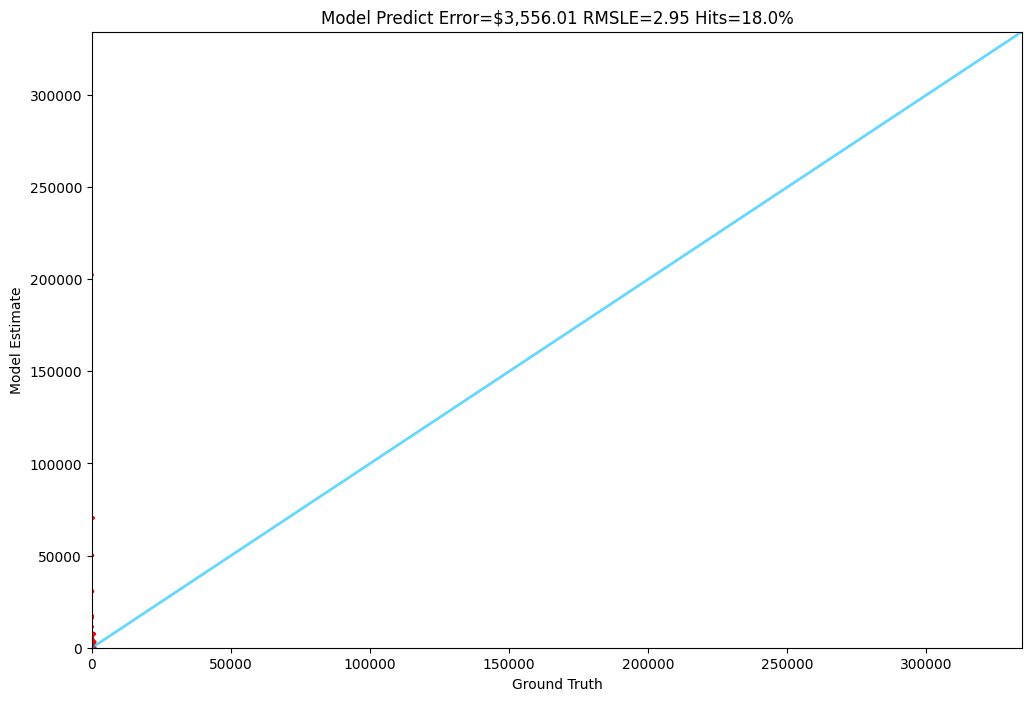

In [14]:
Tester.test(model_predict, test)

LLaMA3.1-8B did considerably worst...

Mean Absolute Error Benchmark:
* Random guesses: `$377.88`
* Bag-of-words: `$104.75`
* Word2Vev: `$100.84`
* Support Vector Machine: `$96.30`
* Random Forest: `$86.08`
* gpt-40-mini: `$75.84`
* finetuned-gpt-4o-mini: `$85.85`
* LLaMA3.1 4-bit: `$3556`

## Train LLaMMA3.1

Let's train the model to see if we can improve the performance.

In [15]:
# Reinitiate Constants
BASE_MODEL = 'unsloth/Meta-Llama-3.1-8B'
HF_USER = 'cshyang'
DATASET_NAME = f'{HF_USER}/amazon-pricer-data'
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True
STEPS = 100 # Save model every 100 steps
SAVE_STEPS = 5000
WANDB_PROJECT_NAME= 'items-pricer'
LOG_TO_WANDB = True

# Metadata for saving model to the hub
RUN_NAME= f"{datetime.now():%Y-%m-%d_%H-%M-%S}"
PROJECT_RUN_NAME = f"{WANDB_PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA
LORA_R = 32
LORA_ALPHA = 64
LORA_DROPOUT = 0.1
TARGET_MODULES = ['q_proj', 'v_proj', 'k_proj', 'o_proj']
# Hyperparameters for training
EPOCHS = 3
BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine' # Cosine decay to
WARMUP_RATIO =  0.03 # 3% of the total training steps are used for warm-up
OPTIMIZER = 'adamw_torch'

In [16]:
# Log in to Weights & Biases
WANDB_API_KEY = userdata.get('WANDB_API_KEY')
if LOG_TO_WANDB:
    os.environ['WANDB_PROJECT'] = WANDB_PROJECT_NAME
    os.environ['WANDB_API_KEY'] = WANDB_API_KEY
    os.environ['WANDB_WATCH'] = 'gradients'
    wandb.init(project=WANDB_PROJECT_NAME, name=RUN_NAME)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cshyang (cshyang-chng). Use `wandb login --relogin` to force relogin


## Data Collator

During the training, there are some constant term in the token prediction. In our case, it's `Price is $`. The model will always predict the value with this prefix.

It's unnecessary for the model to learn how to predict `Price is $` everytime, so the trainer need to teach the model to predict the token(s) after `Price is $`.

There's a complicated way to do this by setting Masks, but luckily Huggingface provides a super simple helper class to take care of that.


In [17]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $" # Tell the model to predict the value after this text in target label
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [18]:
# Reduce the training dataset for faster training
def random_subset(dataset, n):
  # Convert the Dataset object to a list of indices
  indices = list(range(len(dataset)))
  # Sample the indices
  sampled_indices = random.sample(indices, n)
  # Select the corresponding data points from the dataset
  return dataset.select(sampled_indices)

train_sub = random_subset(train, 30000)

## Set up configuration for training

There are 2 parts of the configuration
- lora config
- training SFT config

In [19]:
from trl import SFTTrainer, SFTConfig

# First, specify the configuration parameters for LoRA

lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="prompt",
    save_strategy="epoch", # interchange with "step"
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train_sub,
    peft_config=lora_parameters,
    tokenizer=tokenizer,
    args=train_parameters,
    data_collator=collator
)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [20]:
# Fine-tune!
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

if LOG_TO_WANDB:
  wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss
100,2.068400
200,1.856900
300,1.833000
400,1.854000
500,1.825800
600,1.824600
700,1.798100
800,1.826300
900,1.822600
1000,1.807100


Step,Training Loss
100,2.068400
200,1.856900
300,1.833000
400,1.854000
500,1.825800
600,1.824600
700,1.798100
800,1.826300
900,1.822600
1000,1.807100


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Saved to the hub: items-pricer-2024-10-24_14-25-45


train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,▃▂▂▂▂▂▁▁▂▃▄▂▂▂▂▂▃▂▄▃▄▃▄▄▄▄▃▄▃▇▅▅▆▆▇▆▅█▆▇
train/learning_rate,▅████████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train/loss,█▅▅▅▅▅▅▅▅▅▅▄▄▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁
total_flos,7.230328900968776e+17
train/epoch,3
train/global_step,5625
train/grad_norm,4.78802
train/learning_rate,0.0
train/loss,1.4961


## Finetuned Model Evaluation

Let's use our finedtuned model to do some inference and see how it performs!

In [6]:
# Constants
FINE_TUNED_MODEL= 'cshyang/items-pricer-2024-10-24_14-03-44'
REVISION = None
QUANT_4_BIT = True

In [8]:
# pick the right quantization

if QUANT_4_BIT:
  quantize_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [9]:


tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quantize_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINE_TUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINE_TUNED_MODEL)

print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e9:,.1f} GB")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5.7 GB


In [10]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
    

In [32]:
# Run prediction
def f_model_predict(prompt):
  set_seed(42)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)
  attention_mask = torch.ones(inputs.shape, device=device)
  with torch.no_grad():
    output = fine_tuned_model.generate(inputs, max_new_tokens=10, attention_mask=attention_mask)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
  return extract_price(response)

In [29]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 1

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

1: Guess: $39.00 Truth: $97.99 Error: $58.99 SLE: 0.82 Item: Aukilus LCD Display ...
2: Guess: $91.00 Truth: $116.92 Error: $25.92 SLE: 0.06 Item: Depo Replacement Aut...
3: Guess: $300.00 Truth: $410.00 Error: $110.00 SLE: 0.10 Item: Digital Check CheXpr...
4: Guess: $63.00 Truth: $68.76 Error: $5.76 SLE: 0.01 Item: Greenwald Industries...
5: Guess: $129.00 Truth: $298.59 Error: $169.59 SLE: 0.70 Item: Innovative Mounts Bl...
6: Guess: $134.00 Truth: $228.99 Error: $94.99 SLE: 0.28 Item: A-Premium Hydro-Boos...
7: Guess: $179.00 Truth: $409.95 Error: $230.95 SLE: 0.68 Item: B&M 70418 Tork Maste...
8: Guess: $63.00 Truth: $118.99 Error: $55.99 SLE: 0.40 Item: Boxes Fast Deluxe Li...
9: Guess: $25.00 Truth: $34.99 Error: $9.99 SLE: 0.11 Item: 72 Homemade Mexican ...
10: Guess: $134.00 Truth: $137.12 Error: $3.12 SLE: 0.00 Item: Detroit Axle - Rear ...
11: Guess: $400.00 Truth: $679.99 Error: $279.99 SLE: 0.28 Item: Ronghui F150 Front B...
12: Guess: $134.00 Truth: $86.13 Error: $47.87 S

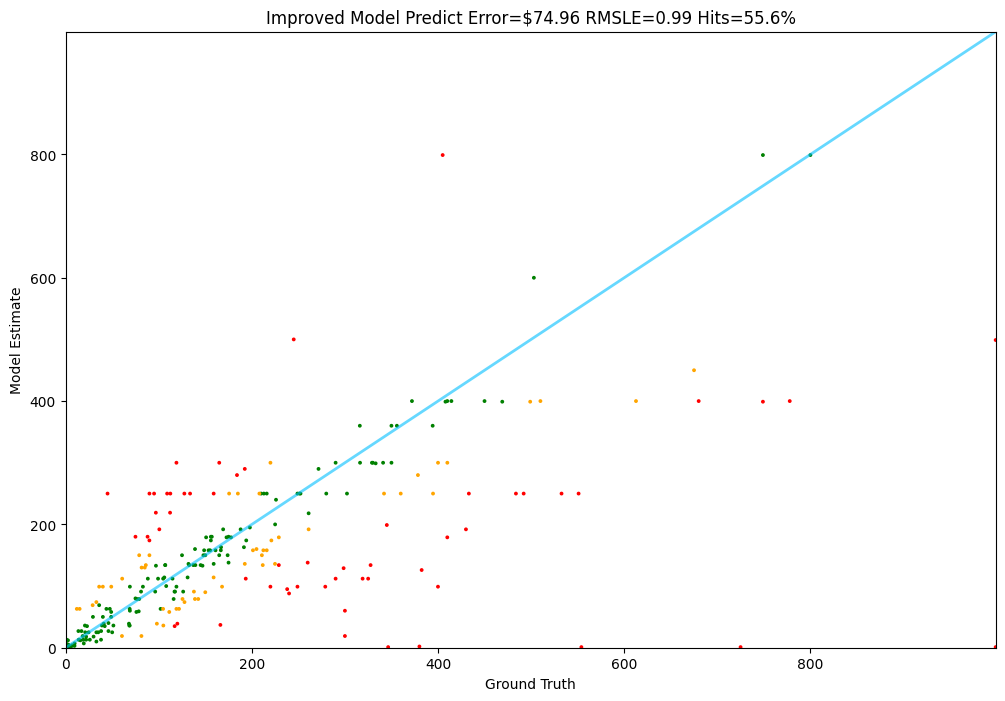

In [28]:
Tester.test(improved_model_predict, test)

1: Guess: $4.00 Truth: $97.99 Error: $93.99 SLE: 8.91 Item: Aukilus LCD Display ...
2: Guess: $4.39 Truth: $116.92 Error: $112.53 SLE: 9.52 Item: Depo Replacement Aut...
3: Guess: $30.00 Truth: $410.00 Error: $380.00 SLE: 6.68 Item: Digital Check CheXpr...
4: Guess: $8.00 Truth: $68.76 Error: $60.76 SLE: 4.19 Item: Greenwald Industries...
5: Guess: $0.00 Truth: $298.59 Error: $298.59 SLE: 32.52 Item: Innovative Mounts Bl...
6: Guess: $1,500.00 Truth: $228.99 Error: $1,271.01 SLE: 3.52 Item: A-Premium Hydro-Boos...
7: Guess: $70,418.00 Truth: $409.95 Error: $70,008.05 SLE: 26.46 Item: B&M 70418 Tork Maste...
8: Guess: $12.00 Truth: $118.99 Error: $106.99 SLE: 4.94 Item: Boxes Fast Deluxe Li...
9: Guess: $72.00 Truth: $34.99 Error: $37.01 SLE: 0.50 Item: 72 Homemade Mexican ...
10: Guess: $10.00 Truth: $137.12 Error: $127.12 SLE: 6.40 Item: Detroit Axle - Rear ...
11: Guess: $150.00 Truth: $679.99 Error: $529.99 SLE: 2.27 Item: Ronghui F150 Front B...
12: Guess: $2,776.00 Truth: $86.13 E

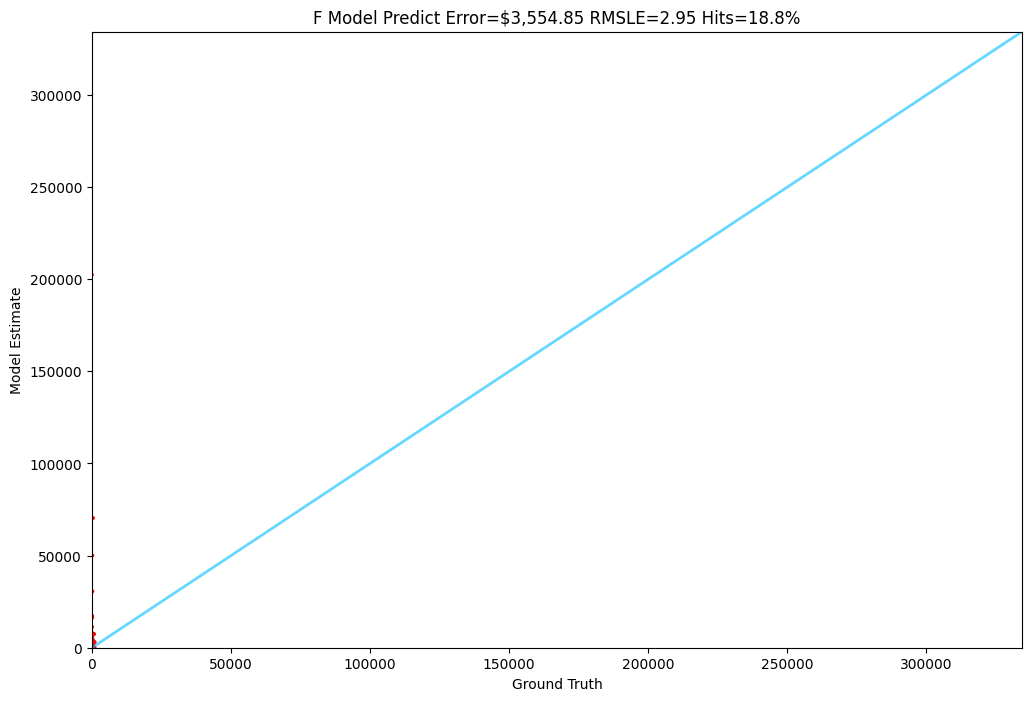

In [33]:
Tester.test(f_model_predict, test)